# Illumination Correction of NF1 Images

## Import libraries

In [1]:
import sys
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from pathlib import Path
import os
import skimage

# explicit import to PyBaSiC due to not having package support
sys.path.append("./PyBaSiC/")
import pybasic

## Helper functions to run PyBaSiC illumination correction
- Allows for PyBaSiC to be run on any image sets and only need to input the path to the directory with the channel folders and the folder name of the channel that you
want to work with.

In [2]:
def load_pybasic_data(
    channels_path: pathlib.Path,
    channel: str,
    file_extension=".tif",
    verbosity: bool = True,
):
    """
    Load all images from a specified directory in preparation for pybasic illum correction

    Parameters:
    channels_path (pathlib.Path): path to directory where the all images for each channel are stored
    channel (str): The name of the channel (currently one of ["GFP", "RFP", "DAPI"])
    file_extension (str): The filename extension of the types of files to search for (default: ".tif")
    verbosity (bool): Prints out information regarding the function running through the images (default: "True")

    Returns:
        channel_images: list of ndarrays of the loaded in images
        image_files: list of strings of the paths to each image
    """
    image_files = (
        []
    )  # List that holds all of the paths to the images in the directory for a specific channel
    image_names = (
        []
    )  # List that holds the names (str) for the images that is used for saving
    images = []  # List of numpy arrays for the images that are read in

    # This for loop will run through the specified directory, find images for a specific channel (channel name is in the file name metadata),
    # save paths to a list, and then save the names to a list after stripping the file_extension
    for image_path in channels_path.iterdir():
        image_path = str(image_path)
        if channel in image_path:
            image_files.append(image_path)
            if image_path.endswith(file_extension):
                image_names.append(image_path.strip(file_extension))

    # Sorts the file paths and names into alphabetical order (puts well C at the start)
    image_files.sort()
    image_names.sort()

    # This for loop will run through the paths to the images for the specified channel and load in the images to be used to illumination correction
    # This code was sampled from the `load_data` function in PyBaSiC
    for i, image_file in enumerate(image_files):
        if verbosity and (i % 10 == 0):
            print(i, "/", len(image_files))
        images.append(skimage.io.imread(image_file))

    return images, image_names


def run_illum_correct(
    channels_path: pathlib.Path,
    save_path: pathlib.Path,
    channel: str,
    output_calc: bool = False,
):
    """calculates flatfield, darkfield, performs illumination correction on channel images, coverts to 8-bit and saves images into designated folder

    Parameters:
        channels_path (pathlib.Path): path to directory where the all images for each channel are stored
        save_path (pathlib.Path): path to directory where the corrected images will be saved to
        channel (str): name of channel
        output_calc (bool): outputs plots of the flatfield and darkfield function for visual review if set to 'True'
    """
    # Loads in the variables returned from "load_pybasic_data" function
    images, image_names = load_pybasic_data(channels_path, channel)

    print("Correcting", {channel})

    flatfield, darkfield = pybasic.basic(images, darkfield=True)

    # Optional output that displays the plots for the flatfield and darkfield calculations if set to True (default is False)
    if output_calc == True:
        plt.title("Flatfield")
        plt.imshow(flatfield)
        plt.colorbar()
        plt.show()
        plt.title("Darkfield")
        plt.imshow(darkfield)
        plt.colorbar()
        plt.show()

    # Run PyBaSiC illumination correction function on loaded in images
    channel_images_corrected = pybasic.correct_illumination(
        images_list=images,
        flatfield=flatfield,
        darkfield=darkfield,
    )

    # Covert illum corrected images to uint8 for downstream analysis
    corrected_images_coverted = np.array(channel_images_corrected)
    corrected_images_coverted[
        corrected_images_coverted < 0
    ] = 0  # makes the negatives 0
    corrected_images_coverted = corrected_images_coverted / np.max(
        corrected_images_coverted
    )  # normalize the data to 0 - 1
    corrected_images_coverted = 255 * corrected_images_coverted  # Scale by 255
    corrected_images = corrected_images_coverted.astype(np.uint8)

    for i, image in enumerate(corrected_images):
        orig_file = image_names[i]
        orig_file_name = orig_file.split("/")[4]
        new_filename = pathlib.Path(f"{save_path}/{orig_file_name}_IllumCorrect.tif")

        # If the image has not been correcrted yet, then the function will save the image. If the image exists, it will skip saving.
        if not new_filename.is_file():
            skimage.io.imsave(new_filename, image)

        else:
            print(f"{new_filename.name} already exists!")

### Implementing helper functions to run illumination correction on each channel for NF1 data

In [3]:
# Set location of input and output locations
channel_path = pathlib.Path("../../0_download_data/NF1_Images")

save_path = pathlib.Path("../Plate1_Corrected_Images")

# Channels to process
channels = ["DAPI", "GFP", "RFP"]

# Perform illumination correction on each channel seperately using a `for` loop:
for channel in channels:
    # print(channel)
    print("Correcting", channel, "channel images")

    # If you want to output the flatfield and darkfield calculations, then put "output_calc=True".
    # If not, leave out from function since it is defaulted to False

    run_illum_correct(
        channel_path,
        save_path,
        channel=channel,
        output_calc=False,
    )

Correcting DAPI channel images
0 / 32
10 / 32
20 / 32
30 / 32
Correcting {'DAPI'}
reweighting_iter: 1


/home/jenna/NF1_SchwannCell_data/1_preprocessing_data/PyBaSiC_Pipelines/./PyBaSiC/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10
C6_01_1_1_DAPI_001_IllumCorrect.tif already exists!
C6_01_1_2_DAPI_001_IllumCorrect.tif already exists!
C6_01_1_3_DAPI_001_IllumCorrect.tif already exists!
C6_01_1_4_DAPI_001_IllumCorrect.tif already exists!
C7_01_1_1_DAPI_001_IllumCorrect.tif already exists!
C7_01_1_2_DAPI_001_IllumCorrect.tif already exists!
C7_01_1_3_DAPI_001_IllumCorrect.tif already exists!
C7_01_1_4_DAPI_001_IllumCorrect.tif already exists!
D6_01_1_1_DAPI_001_IllumCorrect.tif already exists!
D6_01_1_2_DAPI_001_IllumCorrect.tif already exists!
D6_01_1_3_DAPI_001_IllumCorrect.tif already exists!
D6_01_1_4_DAPI_001_IllumCorrect.tif already exists!
D7_01_1_1_DAPI_001_IllumCorrect.tif already exists!
D7_01_1_2_DAPI_001_IllumCorrect.tif already exists!
D7_01_1_3_DAPI_001_IllumCorrect.tif already exists!
D7_01_1_4_DAPI_001_IllumCorrect.tif alr

## Process of PyBaSiC Illumination Correction
**Note:** This section shows the process in which the helper functions are based on.

### Create path and load in images
The directory set up used for this experiment goes as such:
```

├── NF1_SchwannCell_data/
│   ├── 0_download_data/
│   │   ├── NF1_Images/
│   ├── 1_preprocessing_data/
│   │   ├── PyBaSiC_Pipelines/
│   │   │   ├── Corrected_Images/

```

In [4]:
channels_path = pathlib.Path("../PyBaSiC_Pipelines/NF1_Channels/DAPI")
save_path = pathlib.Path("../Corrected_Images")
channel = "DAPI"
file_extension = ".tif"
# Prints out information regarding the function running through the images
verbosity = True

# The for loop is running through the images within the folder designated by channels_path and it will only take the images from a specific channel to save and use
# The load_data function within PyBaSiC is not used for this pipleine due to the function not being as generalizable

image_files = []
image_names = []
images = []

for image_path in channels_path.iterdir():
    image_path = str(image_path)
    if channel in image_path:
        image_files.append(image_path)
        if image_path.endswith(file_extension):
            image_names.append(image_path.strip(file_extension))

image_files.sort()
image_names.sort()

for i, image_file in enumerate(image_files):
    if verbosity and (i % 10 == 0):
        print(i, "/", len(image_files))
    images.append(skimage.io.imread(image_file))

0 / 32
10 / 32
20 / 32
30 / 32


### Run PyBaSiC to calculate the flatfield and darkfield

In [5]:
flatfield, darkfield = pybasic.basic(images, darkfield=True)

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


### Displays the flatfield and darkfield that will be applied to the images

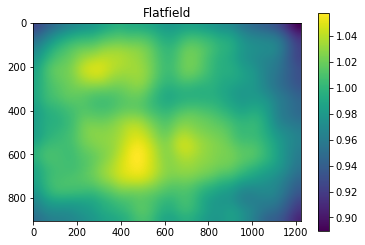

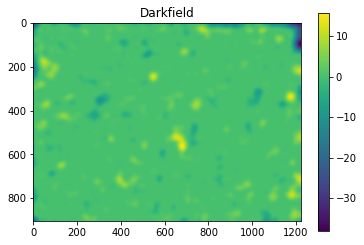

In [6]:
# Based on documentation from the developers, it is recommended to manually check the flatfield function created using the functions below.
# If the flatfield looks smooth, then the correction will be done well.
# If it is noisey, then there is likely an issue with the correction.
# Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5472168/

plt.title("Flatfield")
plt.imshow(flatfield)
plt.colorbar()
plt.show()
plt.title("Darkfield")
plt.imshow(darkfield)
plt.colorbar()
plt.show()

### Run illumination correction

In [7]:
channel_images_corrected = pybasic.correct_illumination(
    images_list=images,
    flatfield=flatfield,
    darkfield=darkfield,
)

### Conversion of Corrected Images

In [8]:
# The default output for the corrected images was not compatable with downstream processes which required code to convert the images to `8-bit`. This code was
# utlized from Mitocheck Data Project - Preprocessing Training Data {https://github.com/WayScience/mitocheck_data/blob/main/1.preprocess_data/preprocess_training_data.ipynb}

corrected_images_coverted = np.array(channel_images_corrected)
corrected_images_coverted[corrected_images_coverted < 0] = 0  # makes the negatives 0
corrected_images_coverted = corrected_images_coverted / np.max(
    corrected_images_coverted
)  # normalize the data to 0 - 1
corrected_images_coverted = 255 * corrected_images_coverted  # Scale by 255
corrected_images = corrected_images_coverted.astype(np.uint8)

### Use `for` loop that adds suffix to corrected images and downloads them

In [9]:
# Recommended to add a suffix that will indicate the which type of image it is, especially if the raw and corrected images look the same to the naked eye.

for i, image in enumerate(corrected_images):
    orig_file = image_names[i]
    orig_file_name = orig_file.split("/")[4]
    new_filename = pathlib.Path(f"{save_path}/{orig_file_name}_IllumCorrect.tif")